# Clasificación de imágenes

Basado en [TUTORIAL TENSORFLOW](https://www.tensorflow.org/tutorials/images/classification?hl=es-419#download_and_explore_the_dataset)

In [ ]:
import datetime
import zoneinfo

# creamos las zonas horarias ( https://nodatime.org/TimeZones )
zona_hermosillo = zoneinfo.ZoneInfo("America/Hermosillo")

In [ ]:
# obtenemos las horas en cada zona horaria
hora_hermosillo = datetime.datetime.now(zona_hermosillo)

# mostramos las horas obtenidas
print(f'Hermosillo,  {hora_hermosillo.hour}:{hora_hermosillo.minute}:{hora_hermosillo.second}')

Hermosillo,  16:38:29


Este tutorial muestra cómo clasificar imágenes de flores. Crea un clasificador de imágenes usando un modelo tf.keras.Sequential y carga datos usando tf.keras.utils.image_dataset_from_directory . Adquirirás experiencia práctica con los siguientes conceptos:

* Carga eficiente de un conjunto de datos fuera del disco.
* Identificar el sobreajuste y aplicar técnicas para mitigarlo, incluido el aumento y la eliminación de datos.

Este tutorial sigue un flujo de trabajo básico de aprendizaje automático:

1. Examinar y comprender los datos.
1. Crear una canalización de entrada
1. Construye el modelo
1. entrenar al modelo
1. Probar el modelo
1. Mejorar el modelo y repetir el proceso

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Descargar el conjunto de datos de flores
Este tutorial utiliza un conjunto de datos de varios miles de fotos de flores. El conjunto de datos de flores contiene cinco subdirectorios, uno por clase:



```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```



In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 6s 0us/step


Después de la descarga, ahora debería tener una copia del conjunto de datos disponible. Hay 3,670 imágenes en total:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

Aquí hay algunas rosas:

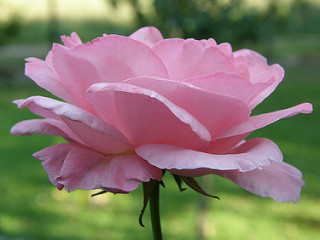

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

Y unos tulipanes:

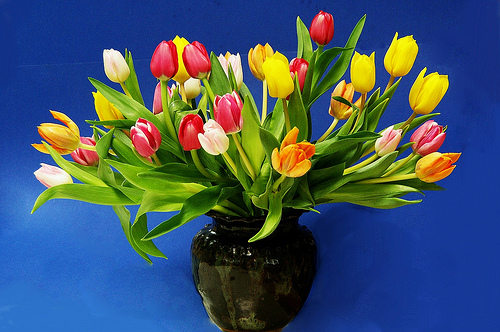

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[6]))

# Cargue datos usando una utilidad Keras

Carguemos estas imágenes fuera del disco utilizando la útil utilidad **tf.keras.utils.image_dataset_from_directory** . Esto lo llevará de un directorio de imágenes en el disco a un **tf.data.Dataset** en solo un par de líneas de código.

## Crear un conjunto de datos
Defina algunos parámetros para el cargador:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Es una buena práctica usar una división de validación al desarrollar su modelo. Usemos el 80% de las imágenes para entrenamiento y el 20% para validación.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset           = "training",
  seed             = 123,
  image_size       = (img_height, img_width),
  batch_size       = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset           = "validation",
  seed             = 123,
  image_size       = (img_height, img_width),
  batch_size       = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Puede encontrar los nombres de clase en el atributo **class_names** en estos conjuntos de datos. Estos corresponden a los nombres de los directorios en orden alfabético.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


##Visualiza los datos

Aquí están las primeras nueve imágenes del conjunto de datos de entrenamiento:

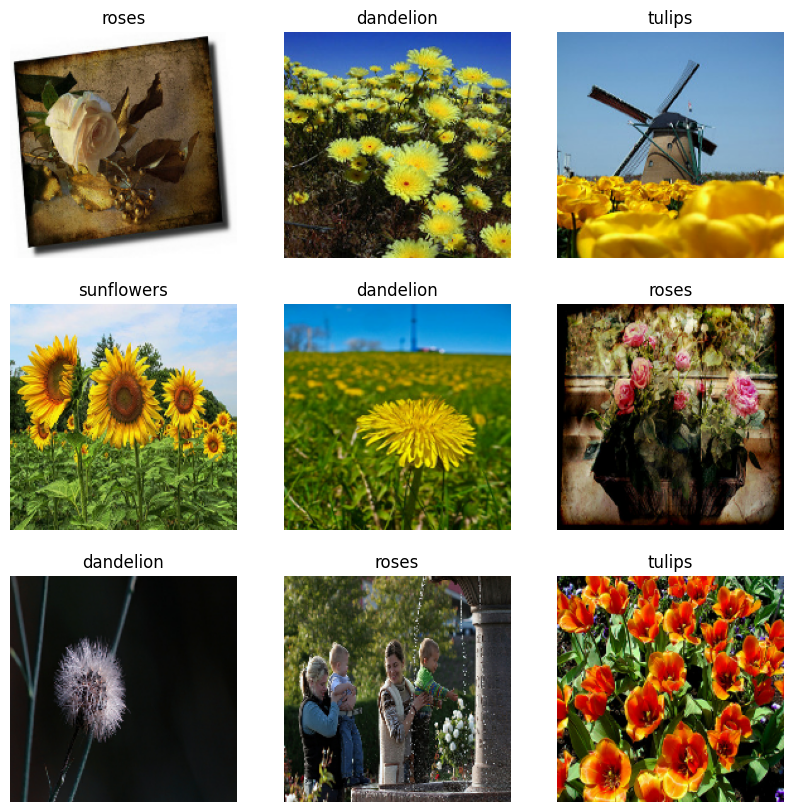

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#for image_batch, labels_batch in train_ds:
  #print(image_batch.shape)
  #print(labels_batch.shape)
  #break

Configurar el conjunto de datos para el rendimiento
Asegurémonos de utilizar la captación previa almacenada en búfer para que pueda obtener datos del disco sin que la E/S se convierta en un bloqueo. Estos son dos métodos importantes que debe usar al cargar datos:

* Dataset.cache mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear un caché en disco de alto rendimiento.
* Dataset.prefetch superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Estandarizar los datos

Los valores del canal RGB están en el rango [0, 255] . Esto no es ideal para una red neuronal; en general, debe buscar que sus valores de entrada sean pequeños.

Aquí, estandarizará los valores para que estén en el rango [0, 1] usando **tf.keras.layers.Rescaling** :

In [ ]:
#normalization_layer = layers.Rescaling(1./255)

In [ ]:
## OPCIóN 1, normalizar los datos de las imagenes previamente a la definicon del modelo
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]

## Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

#Crear el modelo

In [ ]:
#pruebas
num_classes = len(class_names)

model = Sequential([
  layers.InputLayer ( input_shape=(img_height, img_width, 3) ),
  layers.Rescaling(1./255), # OPCIóN2: Reescalar como parte del modelo
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
#num_classes = len(class_names)

#model = Sequential([
 # layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # OPCIóN2: Reescalar como parte del modelo
#  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),

  #layers.Flatten(),
  #layers.Dense(128, activation='relu'),
  #layers.Dense(num_classes)
#])

In [ ]:
22*22*64*128+128

3965056

In [ ]:
model.compile(optimizer = 'adam',
              loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics   = ['accuracy']
              )

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
# obtenemos las horas en cada zona horaria
hora_hermosillo = datetime.datetime.now(zona_hermosillo)

# mostramos las horas obtenidas
print(f'Hermosillo,  {hora_hermosillo.hour}:{hora_hermosillo.minute}:{hora_hermosillo.second}')

Hermosillo,  16:40:42


In [ ]:
# tiempo estimado 35 minutos
epochs=15
%time history1 = model.fit( train_ds, validation_data = val_ds, epochs  = epochs, verbose = 1 )

Epoch 1/15
92/92 [==============================] - 103s 1s/step - loss: 1.2931 - accuracy: 0.4601 - val_loss: 1.1499 - val_accuracy: 0.5218
Epoch 2/15
92/92 [==============================] - 107s 1s/step - loss: 0.9326 - accuracy: 0.6390 - val_loss: 0.9719 - val_accuracy: 0.6213
Epoch 3/15
92/92 [==============================] - 98s 1s/step - loss: 0.7045 - accuracy: 0.7371 - val_loss: 0.9202 - val_accuracy: 0.6471
Epoch 4/15
92/92 [==============================] - 96s 1s/step - loss: 0.4739 - accuracy: 0.8311 - val_loss: 0.9399 - val_accuracy: 0.6485
Epoch 5/15
92/92 [==============================] - 98s 1s/step - loss: 0.2606 - accuracy: 0.9213 - val_loss: 1.1041 - val_accuracy: 0.6567
Epoch 6/15
92/92 [==============================] - 98s 1s/step - loss: 0.1240 - accuracy: 0.9676 - val_loss: 1.4033 - val_accuracy: 0.6526
Epoch 7/15
92/92 [==============================] - 93s 1s/step - loss: 0.0975 - accuracy: 0.9704 - val_loss: 1.5504 - val_accuracy: 0.6281
Epoch 8/15
92/92 [

#Visualiza los resultados del entrenamiento

Cree gráficos de pérdida y precisión en los conjuntos de entrenamiento y validación:

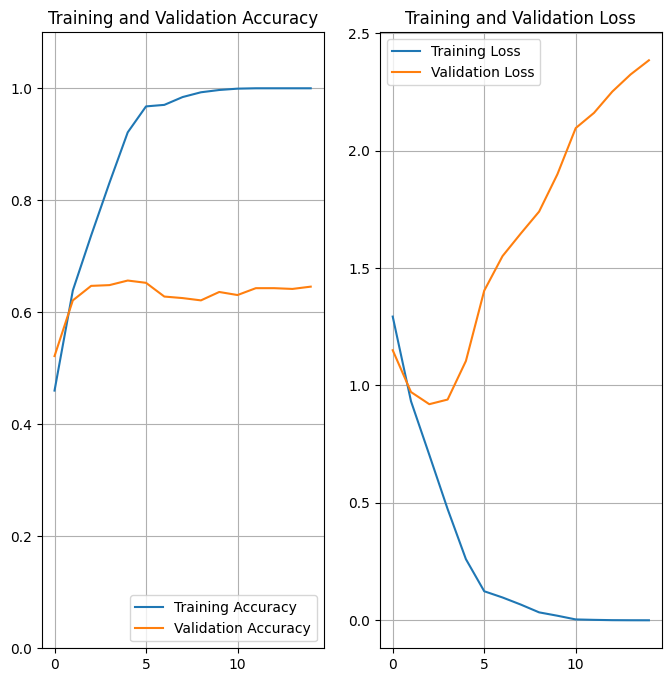

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([0,1.1])
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

Los gráficos muestran que la precisión del entrenamiento y la precisión de la validación están desviadas por amplios márgenes, y el modelo ha logrado solo alrededor del 60 % de precisión en el conjunto de validación.

Inspeccionemos qué salió mal e intentemos aumentar el rendimiento general del modelo.

## Sobreajuste

En los gráficos anteriores, la precisión del entrenamiento aumenta linealmente con el tiempo, mientras que la precisión de la validación se detiene alrededor del 60 % en el proceso de entrenamiento. Además, la diferencia en la precisión entre la precisión del entrenamiento y la validación es notable, un signo de sobreajuste .

Cuando hay una pequeña cantidad de ejemplos de entrenamiento, el modelo a veces aprende de los ruidos o detalles no deseados de los ejemplos de entrenamiento, hasta el punto de afectar negativamente el rendimiento del modelo en los nuevos ejemplos. Este fenómeno se conoce como sobreajuste. Significa que el modelo tendrá dificultades para generalizar en un nuevo conjunto de datos.

Hay múltiples formas de combatir el sobreajuste en el proceso de entrenamiento. En este tutorial, utilizará el aumento de datos y agregará Dropout a su modelo.

##Aumento de datos

El sobreajuste generalmente ocurre cuando hay una pequeña cantidad de ejemplos de entrenamiento. El [aumento de datos](https://www.tensorflow.org/tutorials/images/data_augmentation?hl=es-419) adopta el enfoque de generar datos de entrenamiento adicionales a partir de sus ejemplos existentes al aumentarlos mediante transformaciones aleatorias que producen imágenes de aspecto creíble. Esto ayuda a exponer el modelo a más aspectos de los datos y a generalizar mejor.

Implementará el aumento de datos utilizando las siguientes capas de preprocesamiento de Keras: **tf.keras.layers.RandomFlip**, **tf.keras.layers.RandomRotation** y **tf.keras.layers.RandomZoom**. Estos pueden incluirse dentro de su modelo como otras capas y ejecutarse en la GPU.

In [ ]:
num_classes = len(class_names)
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip    ( "horizontal", input_shape = ( img_height, img_width, 3 ) ),
    layers.RandomRotation( 0.1 ),
    layers.RandomZoom    ( 0.2 ),
  ]
)

Visualicemos cómo se ven algunos ejemplos aumentados aplicando el aumento de datos a la misma imagen varias veces:

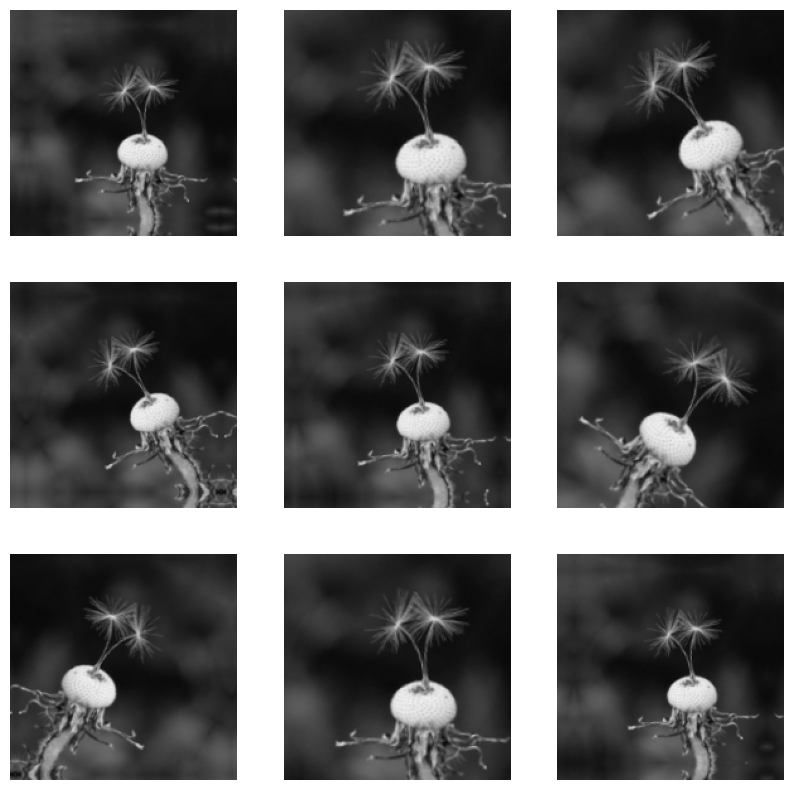

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

##Dropout

Otra técnica para reducir el sobreajuste es introducir la regularización de abandonos en la red.

Cuando aplica abandono a una capa, descarta aleatoriamente (estableciendo la activación en cero) una cantidad de unidades de salida de la capa durante el proceso de entrenamiento. Dropout toma un número fraccionario como su valor de entrada, en forma de 0.1, 0.2, 0.4, etc. Esto significa eliminar aleatoriamente el 10%, 20% o 40% de las unidades de salida de la capa aplicada.

Vamos a crear una nueva red neuronal con tf.keras.layers.Dropout antes de entrenarla usando las imágenes aumentadas:

In [ ]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
# obtenemos las horas en cada zona horaria
hora_hermosillo = datetime.datetime.now(zona_hermosillo)

# mostramos las horas obtenidas
print(f'Hermosillo,  {hora_hermosillo.hour}:{hora_hermosillo.minute}:{hora_hermosillo.second}')

Hermosillo,  17:14:57


In [ ]:
# tiempo estimado 45 minutos
epochs = 15
%time history2 = model2.fit(train_ds, validation_data = val_ds, epochs = epochs,    verbose = 1                  )

Epoch 1/15
92/92 [==============================] - 115s 1s/step - loss: 1.3682 - accuracy: 0.4196 - val_loss: 1.0580 - val_accuracy: 0.5749
Epoch 2/15
92/92 [==============================] - 114s 1s/step - loss: 1.0409 - accuracy: 0.5896 - val_loss: 1.0211 - val_accuracy: 0.5981
Epoch 3/15
92/92 [==============================] - 114s 1s/step - loss: 0.9674 - accuracy: 0.6199 - val_loss: 0.9430 - val_accuracy: 0.6499
Epoch 4/15
92/92 [==============================] - 113s 1s/step - loss: 0.8926 - accuracy: 0.6512 - val_loss: 0.8255 - val_accuracy: 0.6771
Epoch 5/15
92/92 [==============================] - 113s 1s/step - loss: 0.8507 - accuracy: 0.6628 - val_loss: 0.8435 - val_accuracy: 0.6567
Epoch 6/15
92/92 [==============================] - 109s 1s/step - loss: 0.8272 - accuracy: 0.6798 - val_loss: 0.8105 - val_accuracy: 0.6798
Epoch 7/15
92/92 [==============================] - 112s 1s/step - loss: 0.7640 - accuracy: 0.7044 - val_loss: 0.7792 - val_accuracy: 0.6894
Epoch 8/15
92

## Visualiza los resultados del entrenamiento

Después de aplicar el aumento de datos y **tf.keras.layers.Dropout**, hay menos sobreajuste que antes, y la precisión del entrenamiento y la validación están más alineadas:

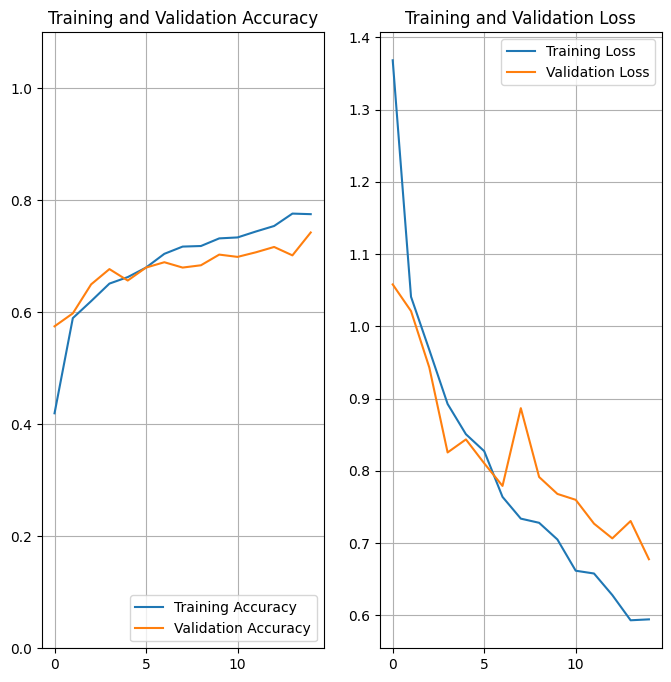

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylim([0,1.1])
plt.grid(True)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

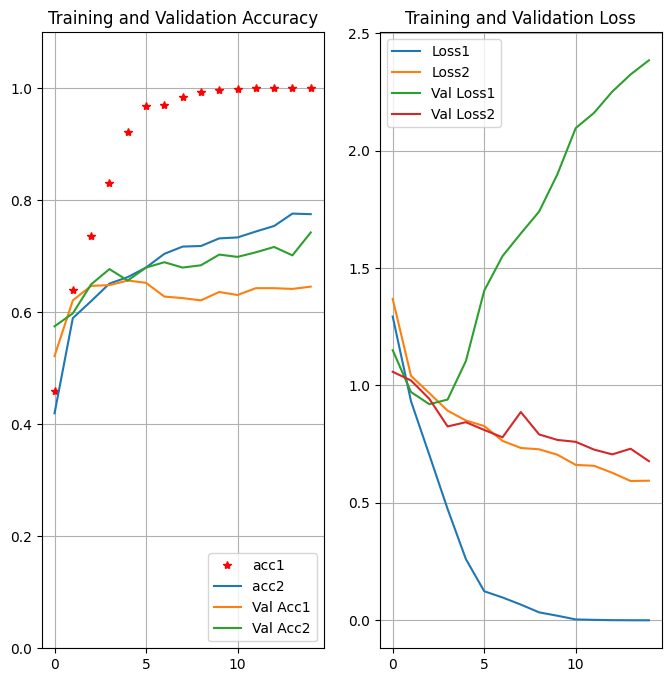

In [ ]:
epochs_range = range(epochs)

acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']


acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, 'r*',label='acc1')
plt.plot(epochs_range, acc,  label='acc2 ')
plt.plot(epochs_range, val_acc1, label='Val Acc1')
plt.plot(epochs_range, val_acc, label='Val Acc2')
plt.ylim([0,1.1])
plt.grid(True)

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Loss1')
plt.plot(epochs_range, loss, label='Loss2')
plt.plot(epochs_range, val_loss1, label='Val Loss1')
plt.plot(epochs_range, val_loss, label='Val Loss2')
plt.grid(True)
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

## Predecir con nuevos datos

Finalmente, usemos nuestro modelo para clasificar una imagen que no se incluyó en los conjuntos de entrenamiento o validación.

In [ ]:
sunflower_url = "https://cdn.britannica.com/36/82536-050-7E968918/Shasta-daisies.jpg"#"https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Daisy', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 180ms/step
This image most likely belongs to daisy with a 77.24 percent confidence.


In [ ]:
print(f'Hermosillo,  {hora_hermosillo.hour}:{hora_hermosillo.minute}:{hora_hermosillo.second}')

Hermosillo,  17:14:57
